Processing images for /home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAM: 100%|██████████| 6160/6160 [00:20<00:00, 301.95it/s]
Processing images for /home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAMPlusPlus: 100%|██████████| 6160/6160 [00:24<00:00, 246.71it/s]
Processing images for /home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/HiResCAM: 100%|██████████| 6160/6160 [00:26<00:00, 234.66it/s]
Processing images for /home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/LayerCAM: 100%|██████████| 6160/6160 [00:28<00:00, 212.85it/s]
Processing images for /home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/XGradCAM: 100%|██████████| 6160/6160 [00:29<00:00, 210.50it/s]


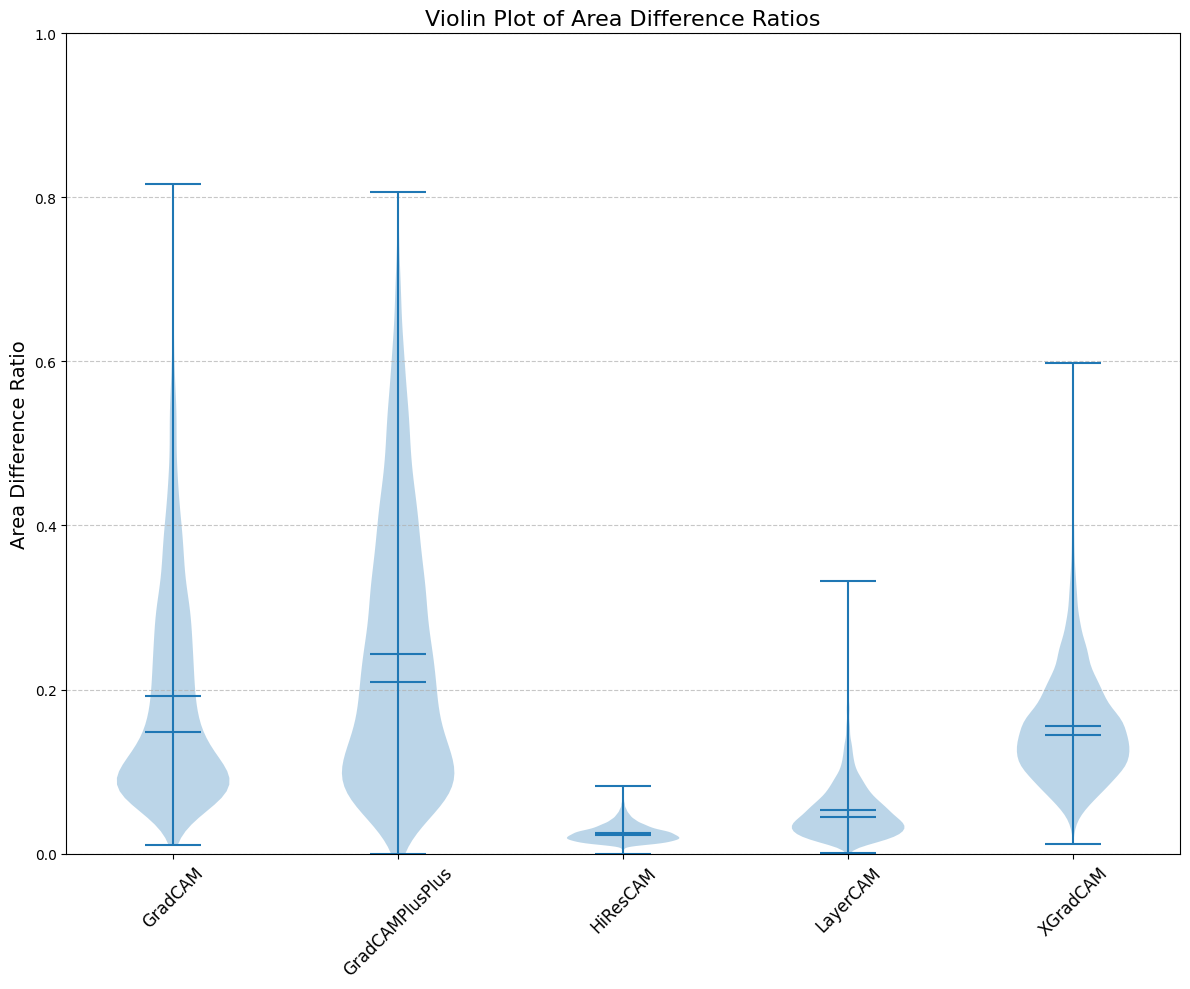

In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

def load_subdirs(dataset_path):
    dataset_path = Path(dataset_path)
    subdirs = [subdir for subdir in dataset_path.iterdir() if subdir.is_dir()]
    subdir_names = [subdir.name for subdir in subdirs]
    return subdir_names, subdirs

def binarize(image, threshold=0.5):
    """Binarize an image based on a threshold."""
    binary_image = (image > threshold).astype(int)
    return binary_image

def area_ratio(image1, image2):
    """Compute the area ratio of two binarized images."""
    area1 = np.sum(image1)
    area2 = np.sum(image2)
    if area1 == 0:
        return float('inf') if area2 != 0 else 1.0
    return area2 / area1

def difference_area_ratio(image1, image2):
    """Compute the ratio of the difference area to the total area of two binarized images."""
    # Find the difference between the two images using XOR
    difference = np.logical_xor(image1, image2).astype(int)
    difference_area = np.sum(difference)
    total_area = image1.shape[0] * image1.shape[1]
    return difference_area / total_area


def process_pair(results_images_path, results_attack_images_path):
    _, subdirs1 = load_subdirs(results_images_path)
    _, subdirs2 = load_subdirs(results_attack_images_path)

    file_names_path2 = [subdir.name for subdir in subdirs2]
    ratios = []

    for file_name in tqdm(file_names_path2, desc=f"Processing images for {results_images_path}"):
        subdir2 = Path(results_attack_images_path) / file_name
        subdir1 = Path(results_images_path) / file_name
        
        if not subdir1.exists():
            #print(f"{file_name} does not exist in path1. Skipping...")
            continue
        
        # Load grayscale images/npy files from both directories
        grayscale_path1 = subdir1 / "grayscale.npy" if (subdir1 / "grayscale.npy").exists() else subdir1 / "grayscale.jpg"
        grayscale_path2 = subdir2 / "grayscale.npy" if (subdir2 / "grayscale.npy").exists() else subdir2 / "grayscale.jpg"
        
        if grayscale_path1.suffix == ".npy":
            grayscale1 = np.load(grayscale_path1)
        else:
            grayscale1 = np.array(Image.open(grayscale_path1))
            
        if grayscale_path2.suffix == ".npy":
            grayscale2 = np.load(grayscale_path2)
        else:
            grayscale2 = np.array(Image.open(grayscale_path2))
        
        # Binarize the grayscale images
        binarized1 = binarize(grayscale1)
        binarized2 = binarize(grayscale2)
        
        # Compute the area ratio of the difference
        ratio = difference_area_ratio(binarized1, binarized2)
        ratios.append(ratio)  # Append to list
        #print(f"Area difference ratio between {file_name}: {ratio:.4f}")
    return ratios


image_paths = [
    ("/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAM", "/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/2_vit/google/vit-large-patch32-384/GradCAM"),
    ("/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/GradCAMPlusPlus", "/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/2_vit/google/vit-large-patch32-384/GradCAMPlusPlus"),
    ("/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/HiResCAM", "/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/2_vit/google/vit-large-patch32-384/HiResCAM"),
    ("/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/LayerCAM", "/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/2_vit/google/vit-large-patch32-384/LayerCAM"),
    ("/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_vit/google/vit-large-patch32-384/XGradCAM", "/home/workstation/code/XAImethods/CAIN/results/imagenet/val_images10k_attack/defocus_blur/2_vit/google/vit-large-patch32-384/XGradCAM"),
]


all_ratios = []

for img_path, attack_path in image_paths:
    ratios = process_pair(img_path, attack_path)
    all_ratios.append(ratios)

# Assuming you've defined your CAM_ALGORITHMS list like this:
CAM_ALGORITHMS = ["GradCAM", "GradCAMPlusPlus", "HiResCAM",  "LayerCAM", "XGradCAM"]

# Plotting the violin plots for all ratios
plt.figure(figsize=(12, 10))
plt.violinplot(all_ratios, showmeans=True, showmedians=True)
plt.title("Violin Plot of Area Difference Ratios", fontsize=16)
plt.ylabel("Area Difference Ratio", fontsize=14)
plt.ylim(0.0, 1)

# Use the CAM_ALGORITHMS names for the x-axis labels
plt.xticks(np.arange(1, len(CAM_ALGORITHMS) + 1), CAM_ALGORITHMS, fontsize=12, rotation=45)  # Added rotation for better visibility

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("violin_plot_all.png", dpi=300)  # Save high-resolution figure
plt.show()


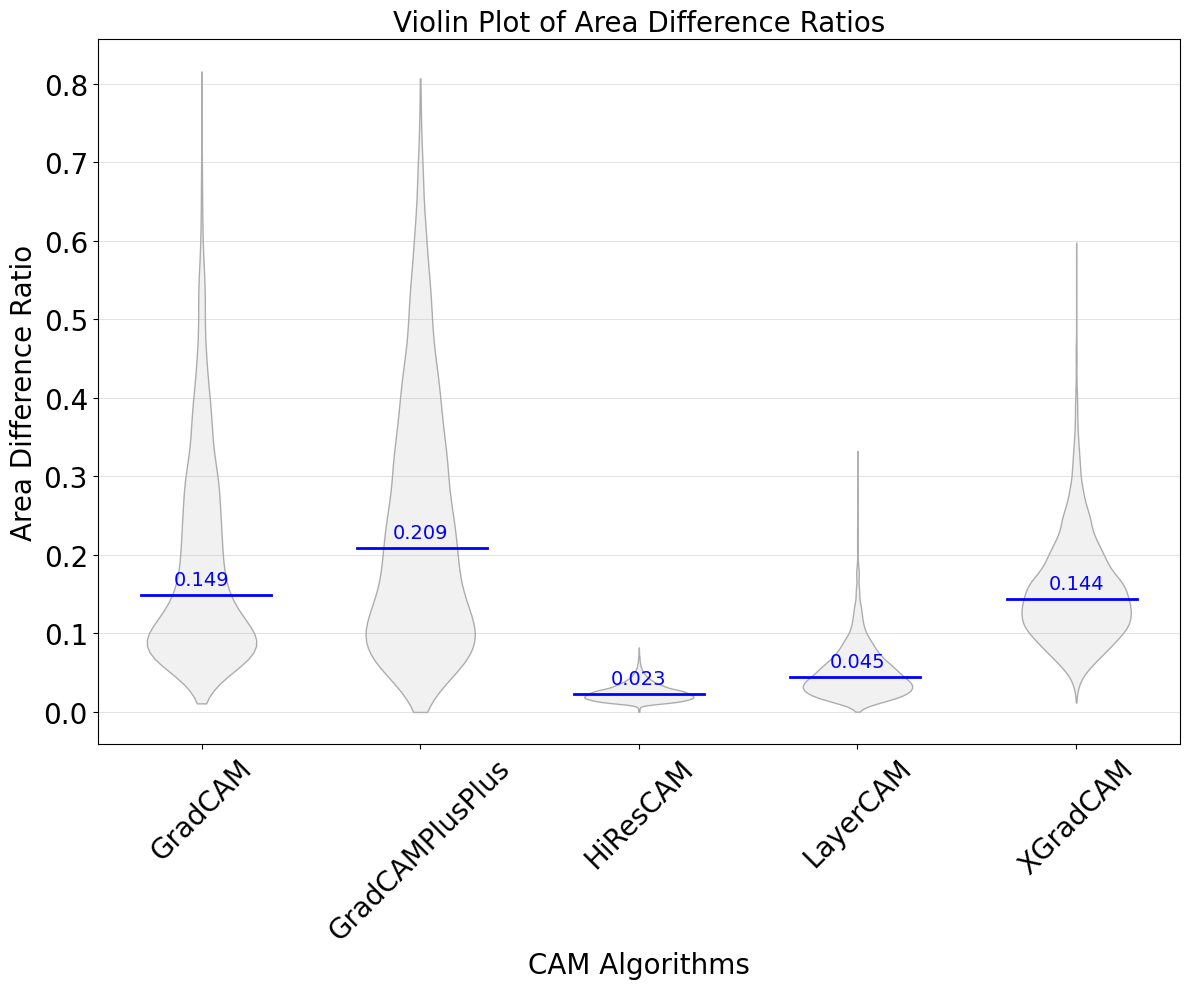

In [5]:
# Assuming you've defined your CAM_ALGORITHMS list like this:
CAM_ALGORITHMS = ["GradCAM", "GradCAMPlusPlus", "HiResCAM", "LayerCAM", "XGradCAM"]

# Plotting the violin plots for all ratios
plt.figure(figsize=(12, 10))
violins = plt.violinplot(all_ratios, showmeans=False, showmedians=False, showextrema=False)
plt.title("Violin Plot of Area Difference Ratios", fontsize=20)
plt.ylabel("Area Difference Ratio", fontsize=20)
plt.xlabel("CAM Algorithms", fontsize=20)

# Color the violin bodies
for body in violins['bodies']:
    body.set_facecolor('#D3D3D3')  # Light gray color for the violin body
    body.set_edgecolor('black')    # Black edge color for the violin body

# Highlight medians
medians = [np.median(value) for value in all_ratios]
for i, median in enumerate(medians, 1):
    plt.axhline(y=median, color='blue', linewidth=2, xmin=(i-1+0.2)/len(medians), xmax=(i-0.2)/len(medians))
    plt.text(i, median + 0.02, f"{median:.3f}", color='blue', va='center', ha='center', fontsize=14)  # Adjust y-value for text positioning if needed

# Use the CAM_ALGORITHMS names for the x-axis labels with increased fontsize
plt.xticks(np.arange(1, len(CAM_ALGORITHMS) + 1), CAM_ALGORITHMS, fontsize=14, rotation=45)  # Increased fontsize

# Increase the fontsize of x and y tick labels
plt.tick_params(axis='both', which='major', labelsize=20)

plt.grid(axis='y', linestyle='-', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.savefig("violin_plot_all_academic.png", dpi=300)
plt.show()


In [3]:
gradcam_data = all_ratios[CAM_ALGORITHMS.index("GradCAM")]
gradcamplusplus_data = all_ratios[CAM_ALGORITHMS.index("GradCAMPlusPlus")]
from scipy.stats import ks_2samp

D, p_value = ks_2samp(gradcam_data, gradcamplusplus_data)
alpha = 0.5
if p_value < alpha:
    print("The two distributions are significantly different (Reject H0)")
else:
    print("The two distributions are not significantly different (Fail to reject H0)")


The two distributions are significantly different (Reject H0)
